<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_1_uncertainty.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Types of Uncertainty

In this assignment, you will explore **epistemic** and **aleatoric** uncertainty in machine learning.
You will use a small dataset to visualize predictions, compute uncertainty, and reflect on the differences between these two key concepts.

---
## Learning Goals
- Understand the difference between **epistemic** (knowledge/model) and **aleatoric** (data/noise) uncertainty
- Learn how to model uncertainty using probability distributions
- Implement uncertainty estimation with a softmax-based classifier
- Visualize how uncertainty appears in decision boundaries
- Practice interpreting results and reflecting on uncertainty in real-world ML tasks

## Part 1 — dataset

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=4, suppress=True)

# Generate a toy dataset
X, y = make_classification(
    n_samples=400, n_features=2, n_redundant=0, n_clusters_per_class=1,
    class_sep=1.0, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Part 2 — Softmax Probabilities (Aleatoric Uncertainty)

Here you’ll train a logistic regression classifier and use its predicted probabilities to measure **aleatoric uncertainty**.
Aleatoric uncertainty shows up when points are near the decision boundary (probabilities close to 0.5).


In [11]:
clf = LogisticRegression().fit(X_train, y_train)

probs = clf.predict_proba(X_test)
preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

Accuracy: 0.875


### TODO:

Find the points that have the most uncertain predictions.  Think about this a little bit - can you come up with a way to quantify a "certain prediction" vs. an "uncertain prediction"?

In [16]:
# XXX your code here

# Take the second value of each pair in probs.
pos_probs = probs[:, 1]

# Calculate how far off of .5 each value in pos_probs is.
# (.5 means there is a 50% chance of the given result; max uncertainty for 2 possible outcomes.)
uncertainty = np.abs(pos_probs - 0.5)

# Show most uncertain predictions
most_uncertain_idx = np.argsort(uncertainty)[:5]
print("Most uncertain samples (indices):", most_uncertain_idx)
print("Probabilities for those samples:\n", probs[most_uncertain_idx])


Most uncertain samples (indices): [ 19 114  69  91  56]
Probabilities for those samples:
 [[0.5315 0.4685]
 [0.5441 0.4559]
 [0.5441 0.4559]
 [0.4549 0.5451]
 [0.424  0.576 ]]


## Part 3 — Visualizing Uncertainty

---

### What is a decision boundary?  
A **decision boundary** is a line that a classifier learns to use to **separate different classes** of data.  
- Points on one side of the boundary are predicted as one class.  
- Points on the other side are predicted as another.  

In two dimensions, we can plot this boundary directly. The shaded regions in the visualization show the classifier’s predicted classes, while the dots are the actual data points.  

Where the dots overlap or cluster near the boundary, the classifier has more difficulty deciding — this is where we see **uncertainty**.  

- **Aleatoric uncertainty**: appears near the decision boundary, caused by noisy or overlapping data.  
- **Epistemic uncertainty**: occurs in regions far away from any training data (where the model is unsure because it has not “seen” those inputs before).  

---

When you look at the plot:  
- The **shaded regions** represent the classifier’s predictions.  
- The **solid boundary line** shows where the model is exactly 50/50 between classes.  
- The **data points** show the ground-truth labels.  

</details>


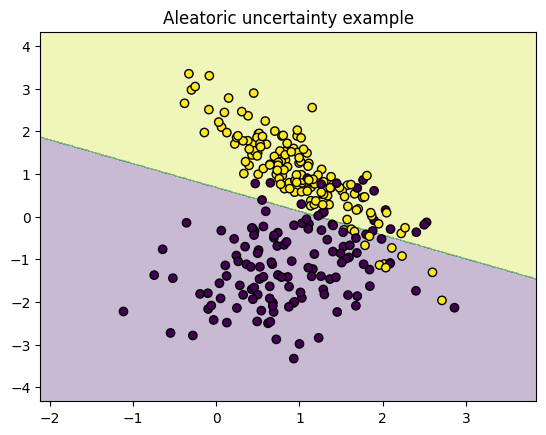

In [17]:
def plot_decision_boundary(clf, X, y, title="Decision boundary"):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    plt.title(title)
    plt.show()

plot_decision_boundary(clf, X_train, y_train, "Aleatoric uncertainty example")

## Part 4 — Epistemic Uncertainty (via Model Variation)

Epistemic uncertainty can be explored by varying the model or subsampling the training data.
We’ll train multiple logistic regression models on bootstrapped samples and measure the variation in predictions.


In [43]:
from sklearn.utils import resample

n_models = 20
all_probs = []

for i in range(n_models):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    clf_boot = LogisticRegression().fit(X_boot, y_boot)
    all_probs.append(clf_boot.predict_proba(X_test))

all_probs = np.array(all_probs)  # shape (n_models, n_samples, n_classes)

# Epistemic uncertainty = variance across models
epistemic_uncertainty = all_probs.var(axis=0).mean(axis=1)

print("Sample epistemic uncertainties:", epistemic_uncertainty[:10])


Sample epistemic uncertainties: [0.0001 0.     0.0012 0.     0.0008 0.0001 0.0011 0.0005 0.0001 0.0001]


### TODO

Now, using the plot_decision_boundary function from Part 3 and the code in Part 4, can you come up with a way to visualize the uncertainty in the decision boundary?

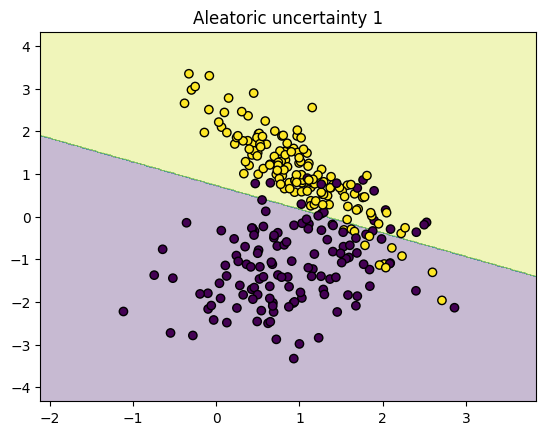

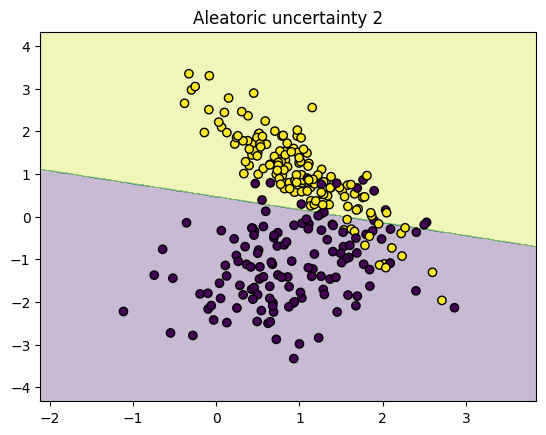

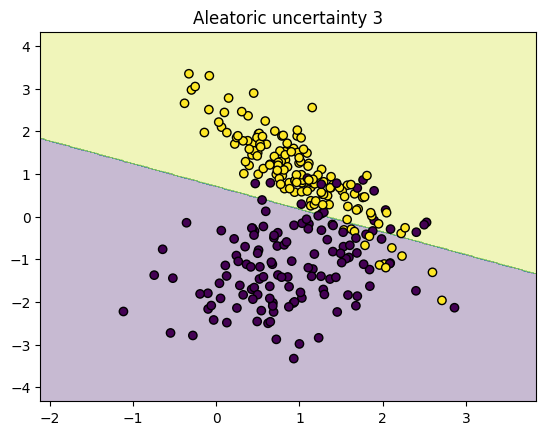

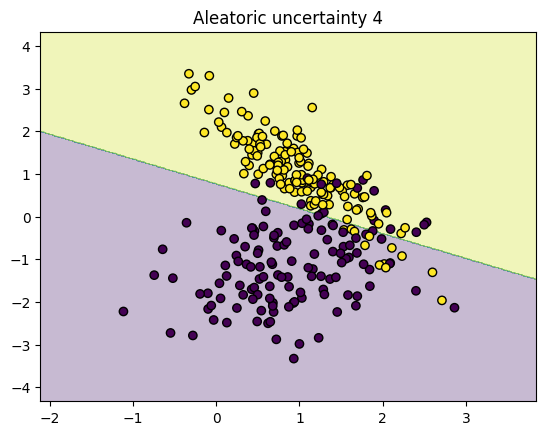

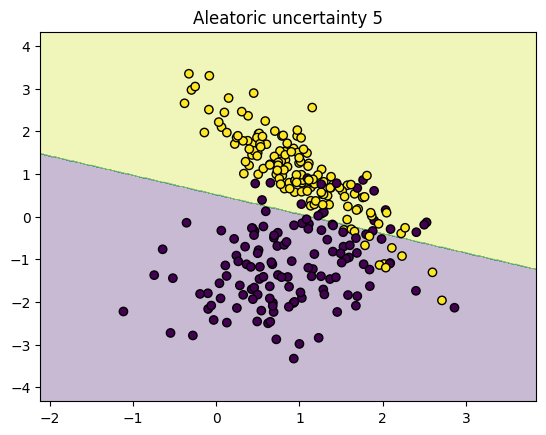

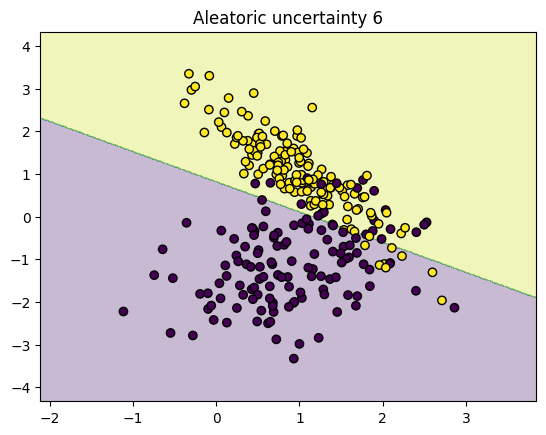

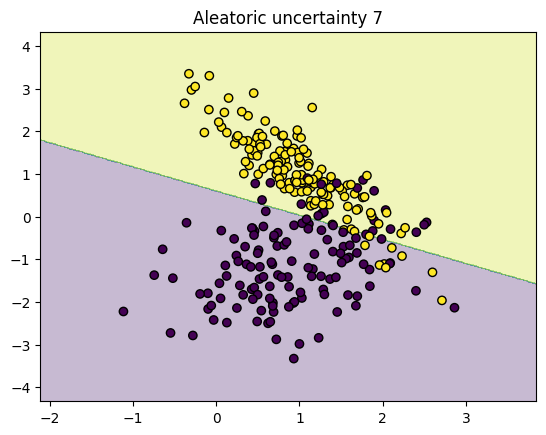

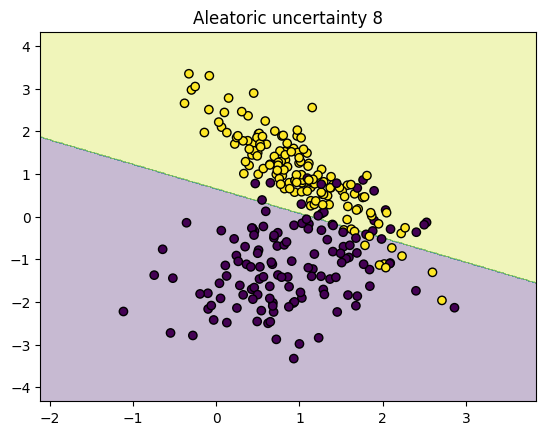

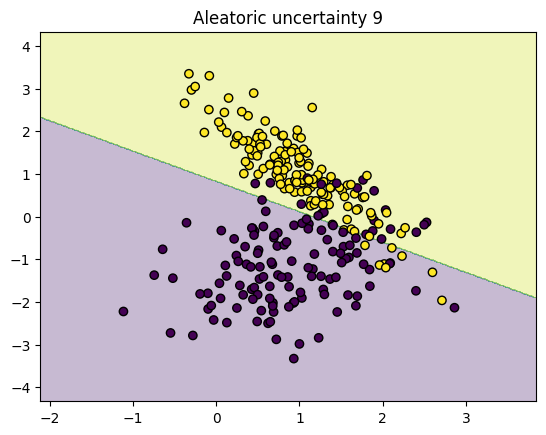

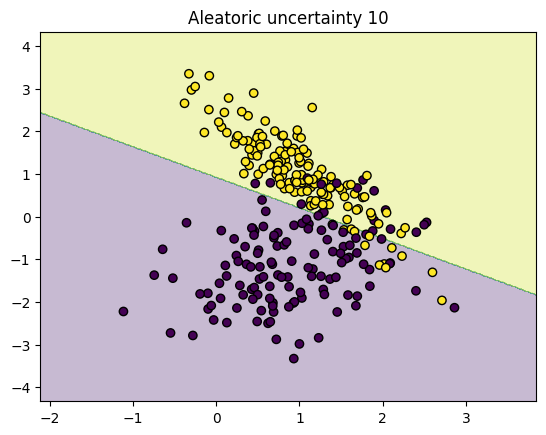

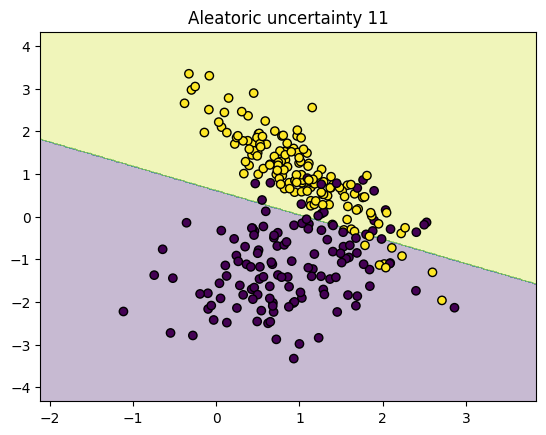

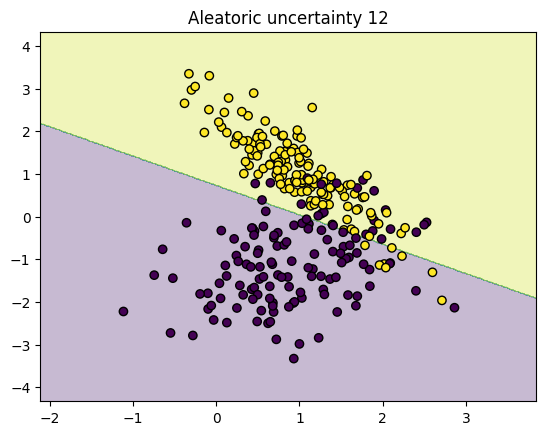

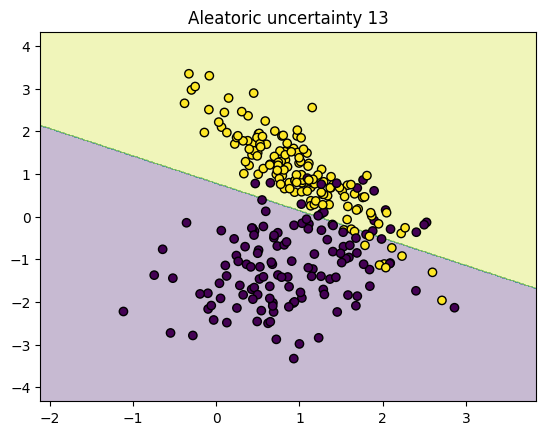

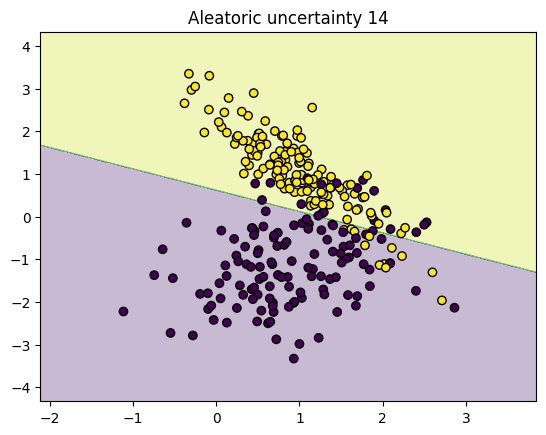

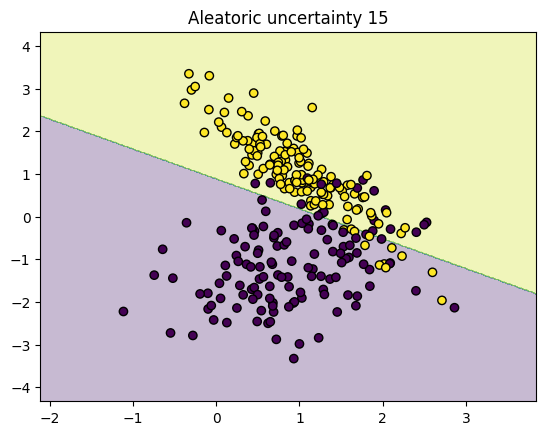

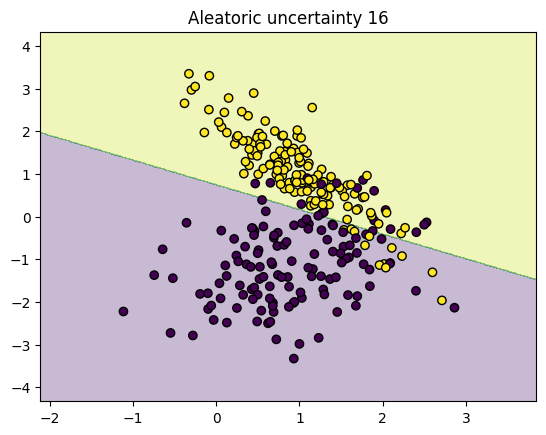

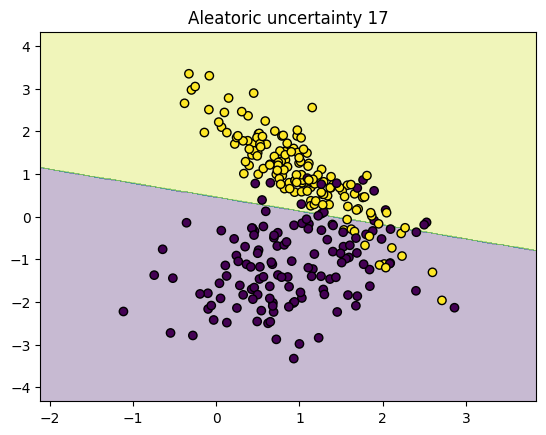

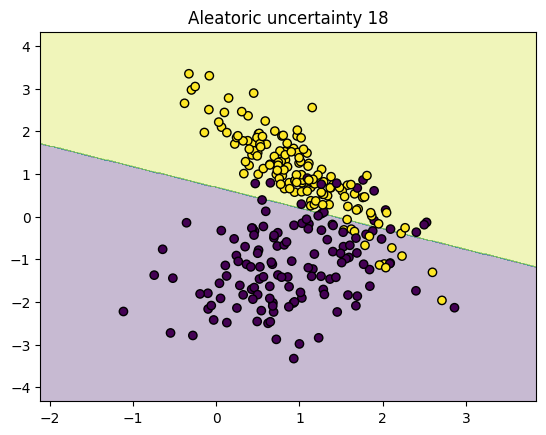

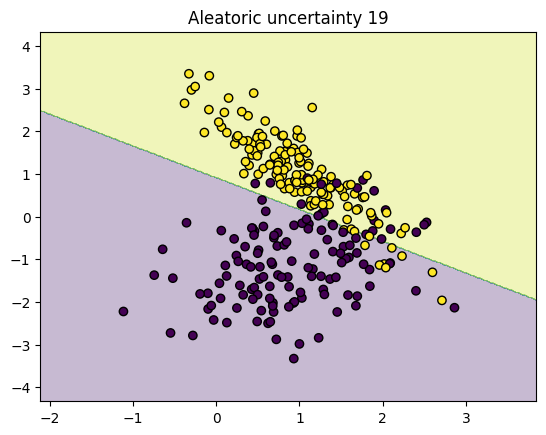

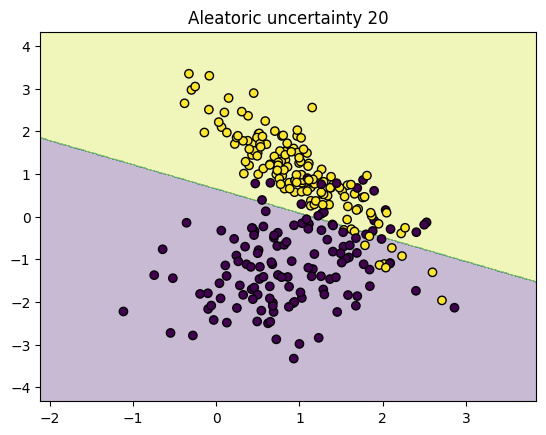

In [41]:
 # XXX your code here

for i in range(n_models):
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=i)
    clf_boot = LogisticRegression().fit(X_boot, y_boot)
    plot_decision_boundary(clf_boot, X_train, y_train, "Aleatoric uncertainty " + str(i + 1))

I'm not positive what this section was looking for in terms of visualization, but I think the point was that the decision boundary fluctuates with each new model, with that fluctuation being stronger the further you get from X = 1.

## Part 5 — Reflection

Answer the following in 2–3 sentences each:

1. Which type of uncertainty did you observe near the decision boundary? Why?

Aleatoric uncertainty appears near the decision boundary. It is caused by noisy or overlapping data.

2. How did epistemic uncertainty change across different bootstrap models?

The largest difference was between 0% epistemic uncertainty and .12%, so it didn't exactly change a lot.
  
3. Give a real-world example where epistemic uncertainty dominates, and one where aleatoric uncertainty dominates.

Epistemic uncertainty comes from a lack of knowledge or data about a system, so would dominate in fields like chess where you're more likely to make a mistake because you missed something rather than bad luck. Aleatoric uncertainty, on the other hand, is the inherent randomness or noise in a system and would dominate in games of chance like coin-flipping or D&D.